<a href="https://colab.research.google.com/github/WestChaeVI/CNN-models/blob/main/ResNet50(91.04%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd

'/content'

In [2]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

# Hyper Parameter

In [4]:
import torch.nn as nn

# 하이퍼파라미터
batch_size = 8
lr = 0.0001
epochs = 100
optimizer_name = 'adam'

model_name = 'GoogLeNet'
criterion = nn.CrossEntropyLoss().to(device) # cost function 패널티 주는 역할

root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
valid_path = '/content/drive/MyDrive/CV_seminar_project/valid'

# Load Dataset

In [5]:
from cv_dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224), # 
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2() # 텐서화만 적용 , pytorch albumentation의 totensor 는 min_max scaling 적용까지
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# Define ResNet50 

In [6]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock
     

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [7]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [8]:
from torchsummary import summary
summary(resnet50, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           1,024
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           4,096
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

In [9]:
from torchvision import models # model 라이브러리
import torch.nn as nn

resnet_50 = models.resnet50(pretrained = True).to(device)
# fine tuning
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8) # 학습을 할수록 학습률 낮춰주는 역할(러닝 보폭 줄이기, 섬세하게 보기위해)

In [11]:
from tqdm import tqdm
from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter
import argparse
import logging
from pathlib import Path
from torch import optim
import numpy as np

train_acc_lst, train_loss_lst, test_acc_lst, test_loss_lst= [], [], [], []

epochs = 100
model_name = 'resnet50'
state={}

for epoch in range(1, epochs+1):

  train_loss = 0.0
  total = 0
  correct = 0
  train_acc = 0
  
  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)

    output = resnet_50(train_img) # 모델에 입력

    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화    
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    train_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1)
   
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct / total)

  train_loss = round(train_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(train_loss)

  # -------------------------------------------------------------------------------------
  test_loss = 0.0
  corrects = 0
  totals = 0
  test_acc = 0

  resnet_50.eval()
  with torch.no_grad():

    for i, (valid_img, valid_label) in enumerate(valid_loader):
          # gpu에 할당
      valid_img = valid_img.to(device)
      valid_label = valid_label.to(device)

      outputs = resnet_50(valid_img) # 모델에 입력
      losses = criterion(outputs, valid_label)

      # loss & acc
      test_loss += losses.item()
      _, predictions = torch.max(outputs.data ,dim = 1 )
    
      totals += valid_label.size(0)
      corrects += (predictions == valid_label).sum().item()
      test_acc += 100 * (corrects / totals)

    test_loss = round(test_loss/(i+1), 3) # 소수점 반올림
    test_acc = round(test_acc/(i+1), 3)
    print(f'Validset {epoch}/{epochs} Loss : {test_loss}, Accuracy : {test_acc}% \n')
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
  
  # 모델 저장
  if np.max(test_acc_lst) <= test_acc:

    state['epoch'] = epoch
    state['net'] = resnet_50.state_dict()

    state['train_loss'] = train_loss
    state['test_loss'] = test_loss

    state['train_acc'] = train_acc
    state['test_acc'] = test_acc
torch.save(state, '/content/drive/MyDrive/CNN models/resnet50_{}_{}.pth'.format(str(state['epoch']), str(state['test_acc'])))


Trainset 1/100 Loss : 0.844, Accuracy : 55.234%
Validset 1/100 Loss : 0.644, Accuracy : 64.78% 

Trainset 2/100 Loss : 0.684, Accuracy : 71.761%
Validset 2/100 Loss : 0.522, Accuracy : 65.61% 

Trainset 3/100 Loss : 0.587, Accuracy : 73.318%
Validset 3/100 Loss : 0.592, Accuracy : 71.755% 

Trainset 4/100 Loss : 0.572, Accuracy : 77.637%
Validset 4/100 Loss : 0.465, Accuracy : 75.508% 

Trainset 5/100 Loss : 0.522, Accuracy : 81.075%
Validset 5/100 Loss : 0.572, Accuracy : 69.51% 

Trainset 6/100 Loss : 0.484, Accuracy : 81.052%
Validset 6/100 Loss : 0.436, Accuracy : 75.617% 

Trainset 7/100 Loss : 0.434, Accuracy : 83.027%
Validset 7/100 Loss : 0.378, Accuracy : 78.309% 

Trainset 8/100 Loss : 0.441, Accuracy : 84.937%
Validset 8/100 Loss : 0.525, Accuracy : 69.638% 

Trainset 9/100 Loss : 0.45, Accuracy : 84.511%
Validset 9/100 Loss : 0.371, Accuracy : 80.956% 

Trainset 10/100 Loss : 0.384, Accuracy : 85.499%
Validset 10/100 Loss : 0.35, Accuracy : 85.096% 

Trainset 11/100 Loss : 

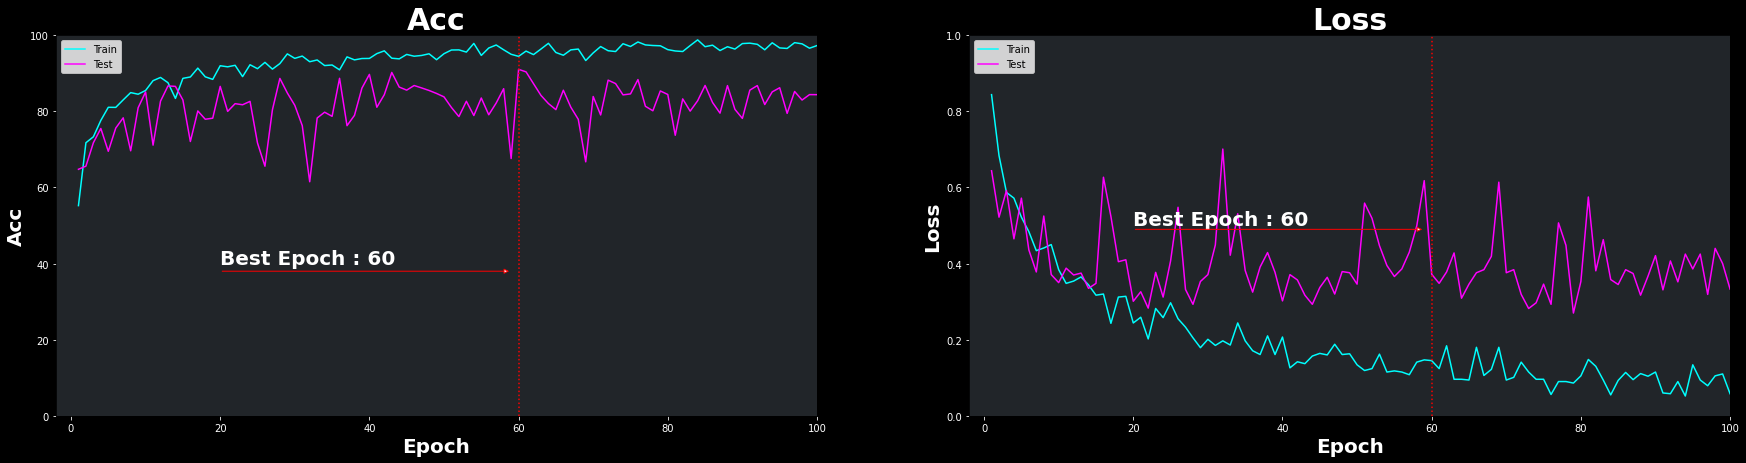

In [18]:
import matplotlib.pyplot as plt
import numpy as np

arrowprops = dict(fc='white', color='red',arrowstyle="-|>")
font1 = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 16}
  

fig = plt.figure(figsize=(30,7),facecolor='black')
plt = fig.subplots(1,2)

train_score = {'Acc':train_acc_lst, 'Loss':train_loss_lst}
valid_score = {'Acc':test_acc_lst, 'Loss':test_loss_lst}

for i in range(len(train_score.keys())):
  plt[i].plot(np.arange(1,len(train_acc_lst)+1),train_score[list(train_score.keys())[i]], c='cyan')
  plt[i].plot(np.arange(1,len(train_acc_lst)+1),valid_score[list(valid_score.keys())[i]],c='magenta')
  plt[i].set_title(list(valid_score.keys())[i],color='white', fontweight='bold', fontsize=30)
  plt[i].set_ylabel(list(valid_score.keys())[i],color='white', fontweight='bold', fontsize=20)
  plt[i].set_xlabel('Epoch',color='white', fontweight='bold', fontsize=20)
  if i == 0:
    plt[i].set_ylim([0,100])
    plt[i].text(state['epoch']-40,40, "Best Epoch : {}".format(state['epoch']), 
            fontdict= {'color':  'white','weight': 'bold','size': 20})
    plt[i].annotate("",xy=(state['epoch']-1, 38),
                xytext=(state['epoch']-40,38),
                arrowprops=arrowprops)
  else:
    plt[i].set_ylim([0,1])
    plt[i].text(state['epoch']-40,0.5, "Best Epoch : {}".format(state['epoch']), 
            fontdict= {'color':  'white','weight': 'bold','size': 20})
    plt[i].annotate("",xy=(state['epoch']-1, 0.49),
                xytext=(state['epoch']-40,0.49),
                arrowprops=arrowprops)

  plt[i].set_xlim([-2, 100])
  plt[i].legend(['Train', 'Test'], loc='upper left')
  plt[i].axvline(x=state['epoch'], color='r', linestyle=':')
  plt[i].tick_params(axis='x', colors='white')
  plt[i].tick_params(axis='y', colors='white')
  plt[i].patch.set_facecolor('#212529')




In [13]:
print('100 epcohs 중 validset 기준 accuracy {} % 성능을 달성하였습니다.'.format(max(test_acc_lst)))

100 epcohs 중 validset 기준 accuracy 91.049 % 성능을 달성하였습니다.
